# This notebook is used to evaluate trained model a

## Example: Raleigh

We now use Raleigh, which is the first as well as trained scenario for testing. Trained models should be evaluated in more scenario in the future

In [1]:
# we need to check if we are using the same conda env as training, which is modelA_sb3

import sys, os
from pathlib import Path
print("sys.executable =", sys.executable)
print("python version =", sys.version)
print("cwd =", os.getcwd())

# Project root
PROJECT_ROOT = Path("/home/jhuang52/Projects/metaRL_merged")

# Ensure we can import project modules
sys.path.insert(0, str(PROJECT_ROOT))

sys.executable = /home/jhuang52/miniconda3/envs/modelA_sb3/bin/python
python version = 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
cwd = /data/jhuang52/Projects/metaRL_merged/eval_tools/model_a


In [2]:
from pathlib import Path
import sys

PROJECT_ROOT = Path("/home/jhuang52/Projects/metaRL_merged").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

from eval_tools.model_a.model_a_functions import (
    generate_gu_trajectory_csv,
    make_gu_trajectory_gif_2d,
    evaluate_over_trajectory_csv,
    save_eval_csv,
    visualize_scene_2d,
    visualize_scene_3d,
    load_gu_trajectory_csv,
    evaluate_over_trajectory_csv_envstep,
    resolve_cfg_paths,
    load_json,
    compute_metrics_from_sinr
)

CFG_PATH = PROJECT_ROOT / "inner_loop/model_a/configs/raleigh_modelA.json"
MODEL_ZIP = PROJECT_ROOT / "inner_loop/model_a/runs/modelA_sb3/SAC_20260128_171021/sac_final.zip"
gu_traj_csv = PROJECT_ROOT / "eval_tools/gu_trajectories/gus_traj_raleigh_T50.csv"

# CFG_PATH = PROJECT_ROOT / "inner_loop/model_a/configs/atlanta_modelA.json"
# MODEL_ZIP = PROJECT_ROOT / "inner_loop/model_a/runs/modelA_sb3/SAC_20260206_002838/sac_final.zip"
# gu_traj_csv = PROJECT_ROOT / "eval_tools/gu_trajectories/gus_traj_atlanta_T50.csv"

In [3]:
import pandas as pd
import numpy as np

df_csv = pd.read_csv(gu_traj_csv)
print("CSV rows:", len(df_csv))
print("CSV unique t:", df_csv["t"].nunique(), "t min/max:", df_csv["t"].min(), df_csv["t"].max())
print("CSV unique gu_id:", df_csv["gu_id"].nunique(), "gu_id min/max:", df_csv["gu_id"].min(), df_csv["gu_id"].max())

# 检查每个 t 是否都有 150 行
counts = df_csv.groupby("t")["gu_id"].count()
print("per-t count min/max:", counts.min(), counts.max())
bad_ts = counts[counts != counts.max()]
print("bad t (count != max):", bad_ts.head(10).to_dict())


CSV rows: 7500
CSV unique t: 50 t min/max: 0 49
CSV unique gu_id: 150 gu_id min/max: 0 149
per-t count min/max: 150 150
bad t (count != max): {}


In [4]:
# ===== Notebook Evaluation Cell (Model A, CSV-driven, env.step() as source of truth) =====

import numpy as np

# 1) build env_ctor: you MUST point to your actual Model-A gym env class
# Example: from inner_loop.model_a.envs.placement_env import SionnaPlacementEnv
from inner_loop.model_a.envs.placement_env import SionnaPlacementEnv # <-- CHANGE to your real env class import

def env_ctor(cfg_dict):
    # cfg_dict is resolved cfg from JSON (dict)
    return SionnaPlacementEnv(cfg_dict)

2026-02-11 18:54:37.960494: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-11 18:54:37.998166: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jhuang52/miniconda3/envs/modelA_sb3/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  wa

In [5]:
import numpy as np

# 0) load cfg / model / traj
cfg_dict = resolve_cfg_paths(load_json(CFG_PATH))
traj = load_gu_trajectory_csv(gu_traj_csv)
print("traj shape:", traj.shape)  # expect (50,150,3)

# 1) build env (IMPORTANT: call reset())
env = env_ctor(cfg_dict)
print("env class:", env.__class__.__name__)

obs0, info0 = env.reset()
print("reset obs len:", len(obs0))
# print("model expects:", model.observation_space.shape)

print("env.n_uav:", getattr(env, "n_uav", None))
print("env.n_gu:", getattr(env, "n_gu", None))

raw = getattr(env, "env_raw", None)
print("has env_raw:", raw is not None)
if raw is not None:
    print("env_raw.n_rx:", getattr(raw, "n_rx", None), "env_raw.n_tx:", getattr(raw, "n_tx", None))
    print("len(env_raw.gus):", len(getattr(raw, "gus", [])))

# 2) check current GU/UAV arrays used for obs
u0 = env._get_uav_xyz()
g0 = env._get_gu_xyz()
print("uav xyz shape:", u0.shape, "=> uav part len:", u0.reshape(-1).shape[0])
print("gu  xyz shape:", g0.shape, "=> gu  part len:", g0.reshape(-1).shape[0])
print("built obs len (from env):", env._build_obs().shape[0])

# 3) now inject CSV GU positions and re-check
gu_xyz = traj[0].astype(np.float32)
print("CSV gu_xyz shape:", gu_xyz.shape)

env.set_gu_xyz(gu_xyz)

g1 = env._get_gu_xyz()
print("after set_gu_xyz -> gu xyz shape:", g1.shape, "=> gu part len:", g1.reshape(-1).shape[0])
print("built obs len (after set):", env._build_obs().shape[0])


traj shape: (50, 150, 3)
env class: SionnaPlacementEnv
reset obs len: 465
env.n_uav: 5
env.n_gu: 150
has env_raw: True
env_raw.n_rx: 150 env_raw.n_tx: 5
len(env_raw.gus): 150
uav xyz shape: (5, 3) => uav part len: 15
gu  xyz shape: (150, 3) => gu  part len: 450
built obs len (from env): 465
CSV gu_xyz shape: (150, 3)
after set_gu_xyz -> gu xyz shape: (150, 3) => gu part len: 450
built obs len (after set): 465


In [6]:
# # ===== Notebook Evaluation Cell (Model A, CSV-driven, env.step() as source of truth) =====

# import numpy as np

# # 1) build env_ctor: you MUST point to your actual Model-A gym env class
# # Example: from inner_loop.model_a.envs.placement_env import SionnaPlacementEnv
# from inner_loop.model_a.envs.placement_env import SionnaPlacementEnv # <-- CHANGE to your real env class import

# def env_ctor(cfg_dict):
#     # cfg_dict is resolved cfg from JSON (dict)
#     return SionnaPlacementEnv(cfg_dict)

# 2) run evaluation (multi-step, return sinr + radiomap through info/cache)
df, cache = evaluate_over_trajectory_csv_envstep(
    cfg_path=CFG_PATH,
    model_zip_path=MODEL_ZIP,
    gu_traj_csv=gu_traj_csv,
    env_ctor=env_ctor,
    t_start=0,
    t_end=50,
    deterministic=True,
    action_mode="absolute",   # kept for compatibility; env action space should already match training
    save_cache=True,
)

display(df.head(10))

# 3) quick sanity checks: what did we actually cache?
print("cache keys:", None if cache is None else list(cache.keys()))
if cache is not None:
    t0 = int(df["t"].iloc[0])
    print("example t:", t0)
    print("uav_xyz[t].shape:", cache["uav_xyz"][t0].shape)
    print("gu_xyz[t].shape:", cache["gu_xyz"][t0].shape)
    print("sinr_db_gu_tx[t].shape:", cache["sinr_db_gu_tx"][t0].shape)
    print("has radio_map[t]:", t0 in cache.get("radio_map", {}))

# 4) access radiomap / sinr for a specific step t
t_pick = 0
sinr_db_gu_tx = None if cache is None else cache["sinr_db_gu_tx"][t_pick]
radio_map = None if cache is None else cache.get("radio_map", {}).get(t_pick, None)

print("t_pick =", t_pick)
print("sinr_db_gu_tx:", None if sinr_db_gu_tx is None else sinr_db_gu_tx.shape)
print("radio_map:", type(radio_map))

,t,reward,invalid_uav_count,coverage_tau_db,coverage_count,coverage_ratio,best_sinr_mean,best_sinr_min,best_sinr_max,load_var,...,rinfo/coverage_count,rinfo/coverage_frac,rinfo/sinr_target_db,rinfo/sinr_score_raw,rinfo/sinr_score_norm,rinfo/load_var,rinfo/per_uav_load_max,rinfo/per_uav_load_mean,rinfo/per_uav_load_min,rinfo/invalid_uav_count
0,0,-195.219139,0,5.0,55,0.366667,5496749.5,0.0,205273360.0,987.387634,...,55.0,0.366667,8.0,43803046.75,1.891721,987.387634,98.0,27.200001,4.0,0.0
1,1,-210.204773,0,5.0,52,0.346667,6429397.5,0.0,205273360.0,1061.959106,...,52.0,0.346667,8.0,44269370.75,1.840381,1061.959106,101.0,27.799999,6.0,0.0
2,2,-238.493298,0,5.0,47,0.313333,4856839.0,0.0,111759160.0,1202.816284,...,47.0,0.313333,8.0,24780251.50,1.756626,1202.816284,106.0,28.200001,3.0,0.0
3,3,-227.065307,0,5.0,48,0.320000,4595717.0,0.0,108767088.0,1145.959106,...,48.0,0.320000,8.0,24051276.10,1.806514,1145.959106,104.0,28.000000,5.0,0.0
4,4,-190.973567,0,5.0,58,0.386667,5019072.0,0.0,107498816.0,966.530640,...,58.0,0.386667,8.0,24009299.20,1.945894,966.530640,97.0,28.200001,6.0,0.0
5,5,-255.146772,0,5.0,42,0.280000,5169915.0,0.0,107498816.0,1285.673462,...,42.0,0.280000,8.0,24084720.70,1.707921,1285.673462,109.0,28.200001,3.0,0.0
6,6,-202.736715,0,5.0,48,0.320000,4855390.0,0.0,212778352.0,1024.244873,...,48.0,0.320000,8.0,44983365.40,1.792260,1024.244873,99.0,28.400000,5.0,0.0
7,7,-251.021558,0,5.0,49,0.326667,5709239.5,0.0,201221264.0,1265.673462,...,49.0,0.326667,8.0,43098872.55,1.786468,1265.673462,108.0,28.600000,2.0,0.0
8,8,-216.413064,0,5.0,54,0.360000,7777537.5,0.0,213417648.0,1093.387695,...,54.0,0.360000,8.0,46572298.35,1.904475,1093.387695,102.0,28.600000,7.0,0.0
9,9,-194.914049,0,5.0,54,0.360000,5631582.0,0.0,224737984.0,985.673401,...,54.0,0.360000,8.0,47763387.80,1.860631,985.673401,98.0,27.600000,6.0,0.0


cache keys: ['uav_xyz', 'gu_xyz', 'sinr_db_gu_tx', 'radio_map', 'info']
example t: 0
uav_xyz[t].shape: (5, 3)
gu_xyz[t].shape: (150, 3)
sinr_db_gu_tx[t].shape: (150, 7)
has radio_map[t]: True
t_pick = 0
sinr_db_gu_tx: (150, 7)
radio_map: <class 'sionna.rt.radio_map_solvers.planar_radio_map.PlanarRadioMap'>


NameError: name 'compute_metrics_from_sinr' is not defined

Visualize heatmap and user_sinr to see the real performance during evaluation.

In [16]:
from eval_tools.model_a.model_a_functions import (
    compute_metrics_from_sinr
)
# 5) (optional) compute any extra metrics you want from sinr_db_gu_tx at time t_pick
metrics_t = compute_metrics_from_sinr(resolve_cfg_paths(load_json(CFG_PATH)), sinr_db_gu_tx)
print(metrics_t)

{'coverage_tau_db': 5.0, 'coverage_count': 55, 'coverage_ratio': 0.36666666666666664, 'best_sinr_mean': 5496749.5, 'best_sinr_min': 0.0, 'best_sinr_max': 205273360.0, 'load_var': 987.3876342773438, 'per_uav_load': array([98.,  4., 10., 11., 13.], dtype=float32), 'per_uav_load_min': 4.0, 'per_uav_load_mean': 27.200000762939453, 'per_uav_load_max': 98.0}


In [10]:
import numpy as np

t = 0
sinr_db = cache["sinr_db_gu_tx"][t]  # (n_gu, n_tx)
n_gu, n_tx = sinr_db.shape
print("n_gu, n_tx =", n_gu, n_tx)

rm = cache["radio_map"][t]
print("radio_map type:", type(rm))
print("radio_map dir sample:", [k for k in dir(rm) if "grid" in k.lower() or "map" in k.lower() or "value" in k.lower()][:40])


n_gu, n_tx = 150 7
radio_map type: <class 'sionna.rt.radio_map_solvers.planar_radio_map.PlanarRadioMap'>
radio_map dir sample: ['_pathgain_map', 'transmitter_radio_map']


In [11]:
def _get_first_existing_attr(obj, names):
    for n in names:
        if hasattr(obj, n):
            return getattr(obj, n)
    return None

def extract_planar_radiomap_arrays(rm):
    """
    Try to extract:
      - values: heatmap tensor (possibly multi-tx)
      - x_coords, y_coords: 1D coordinates of the planar grid (or 2D mesh)
    Returns:
      values, x, y
    """
    # ---- 1) Try to find a "values" tensor ----
    # Common candidates you may see in Sionna RT objects:
    candidates = [
        "values", "value", "data", "tensor", "map", "radio_map",
        "path_gain", "rx_power", "sinr", "snr", "rss", "rsrp"
    ]
    values = None
    for c in candidates:
        v = _get_first_existing_attr(rm, [c])
        if v is None:
            continue
        # some fields may be methods, skip callables
        if callable(v):
            continue
        # accept numpy / tf tensors
        values = v
        break

    # If still none, try scanning attributes for array-like objects
    if values is None:
        array_like = []
        for k in dir(rm):
            if k.startswith("_"):
                continue
            v = getattr(rm, k)
            if callable(v):
                continue
            if isinstance(v, (np.ndarray,)):
                array_like.append((k, v.shape, v.dtype))
        raise RuntimeError(
            "Cannot find heatmap values in radio_map. "
            f"Found array-like attrs: {array_like[:30]}"
        )

    # Convert to numpy if needed (e.g., tf.Tensor)
    try:
        values_np = np.array(values)
    except Exception as e:
        raise RuntimeError(f"Failed to convert radio_map values to numpy: {e}")

    # ---- 2) Try to find grid coordinates ----
    # Planar maps often have something like rm.x, rm.y or rm.grid or rm.center/extent
    x = _get_first_existing_attr(rm, ["x", "x_coords", "xs", "x_grid"])
    y = _get_first_existing_attr(rm, ["y", "y_coords", "ys", "y_grid"])
    grid = _get_first_existing_attr(rm, ["grid", "coords", "coordinates"])

    # Convert x/y if present
    if x is not None:
        try:
            x = np.array(x)
        except:
            x = None
    if y is not None:
        try:
            y = np.array(y)
        except:
            y = None

    # If x/y missing, we keep None and will still plot with imshow index space
    return values_np, x, y

rm = cache["radio_map"][0]
vals, x, y = extract_planar_radiomap_arrays(rm)
print("radio_map values shape:", vals.shape)
print("x:", None if x is None else x.shape, "y:", None if y is None else y.shape)


radio_map values shape: (7, 400, 400)
x: None y: None


In [12]:
import matplotlib.pyplot as plt

def normalize_to_nTx_H_W(vals, n_tx_hint=None):
    """
    Convert vals to (n_tx, H, W) if possible.
    Supports:
      - (H, W, n_tx)
      - (n_tx, H, W)
      - (H, W) -> (1, H, W)
    """
    vals = np.array(vals)
    if vals.ndim == 2:
        return vals[None, :, :]  # (1,H,W)

    if vals.ndim != 3:
        raise ValueError(f"Unexpected radio_map tensor ndim={vals.ndim}, shape={vals.shape}")

    a, b, c = vals.shape
    # If last dim matches n_tx
    if n_tx_hint is not None and c == n_tx_hint:
        return np.transpose(vals, (2, 0, 1))  # (n_tx,H,W)
    # If first dim matches n_tx
    if n_tx_hint is not None and a == n_tx_hint:
        return vals  # already (n_tx,H,W)

    # Otherwise guess: if c is small like <=32 it could be n_tx
    if c <= 64:
        return np.transpose(vals, (2, 0, 1))
    if a <= 64:
        return vals

    # ambiguous
    raise ValueError(f"Cannot infer tx dimension. shape={vals.shape}, n_tx_hint={n_tx_hint}")

def plot_per_tx_heatmaps(vals_nTx_H_W, title_prefix="TX", max_cols=4):
    n_tx = vals_nTx_H_W.shape[0]
    cols = min(max_cols, n_tx)
    rows = int(np.ceil(n_tx / cols))

    plt.figure(figsize=(4*cols, 4*rows))
    for i in range(n_tx):
        ax = plt.subplot(rows, cols, i+1)
        im = ax.imshow(vals_nTx_H_W[i], origin="lower")
        ax.set_title(f"{title_prefix} {i}")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


vals_tx shape (n_tx,H,W): (7, 400, 400)


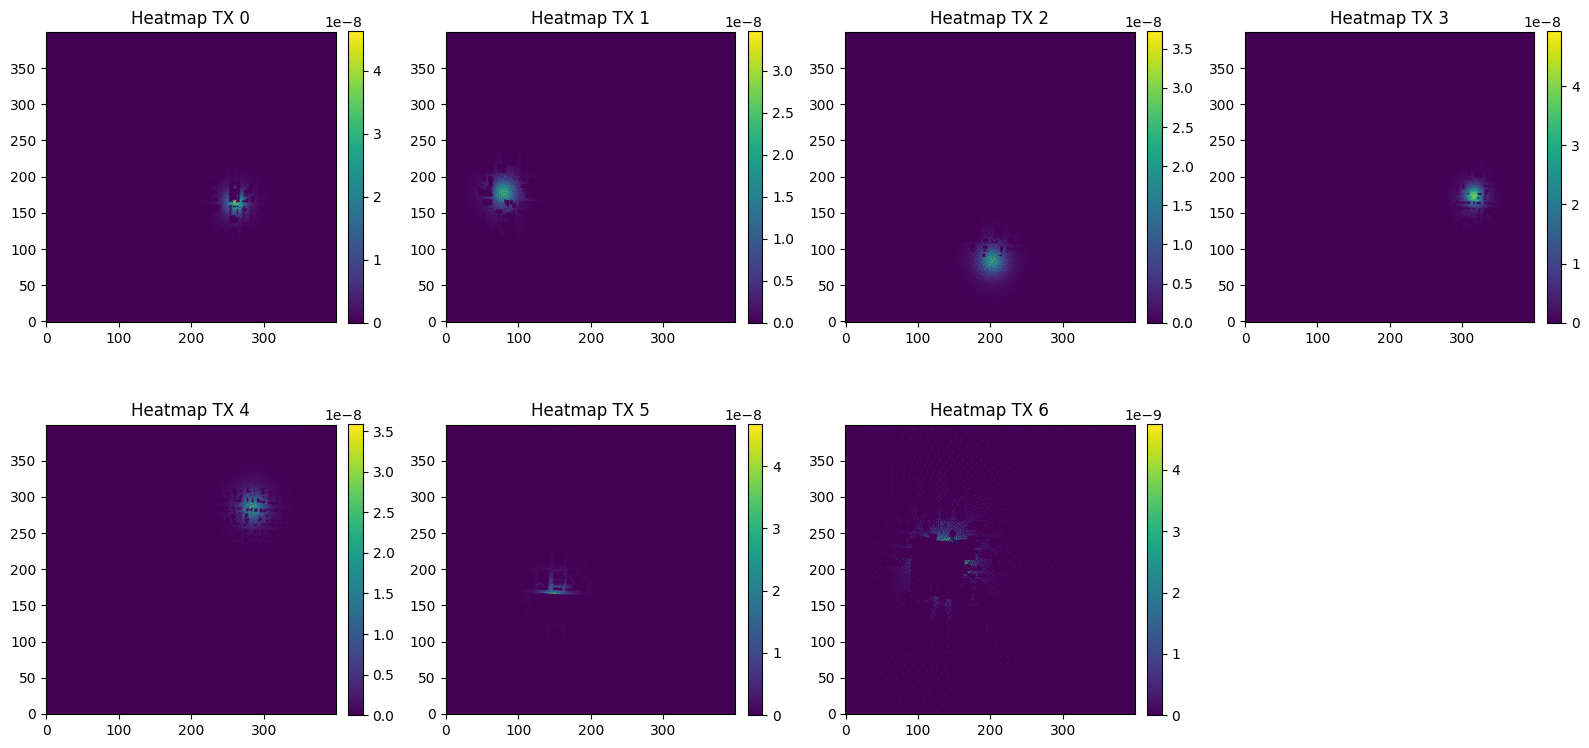

In [13]:
t = 0
n_tx = cache["sinr_db_gu_tx"][t].shape[1]

rm = cache["radio_map"][t]
vals, x, y = extract_planar_radiomap_arrays(rm)
vals_tx = normalize_to_nTx_H_W(vals, n_tx_hint=n_tx)

print("vals_tx shape (n_tx,H,W):", vals_tx.shape)
plot_per_tx_heatmaps(vals_tx, title_prefix="Heatmap TX")


In [14]:
t = 0
sinr_db = cache["sinr_db_gu_tx"][t]          # (n_gu,n_tx)
gu_xyz = cache["gu_xyz"][t]                  # (n_gu,3)

best_tx = np.argmax(sinr_db, axis=1)         # (n_gu,)
best_sinr = np.max(sinr_db, axis=1)          # (n_gu,)

print("best_sinr dB:", best_sinr[:10])
print("best_tx idx:", best_tx[:10])

best_sinr dB: [      0.  8551090.        0.  1688210.8       0.  3481358.        0.
 7548717.5       0.        0. ]
best_tx idx: [0 4 0 4 0 3 0 3 0 0]


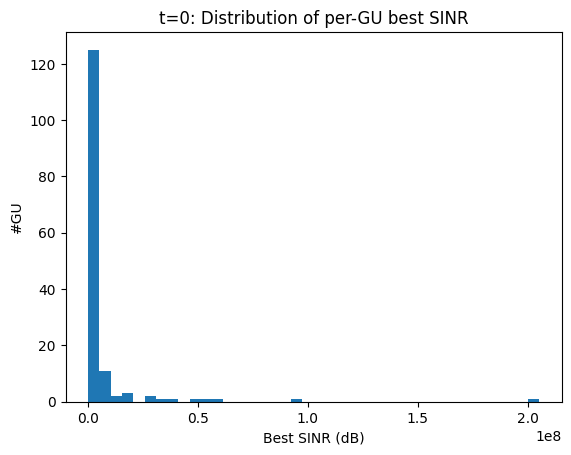

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(best_sinr, bins=40)
plt.xlabel("Best SINR (dB)")
plt.ylabel("#GU")
plt.title(f"t={t}: Distribution of per-GU best SINR")
plt.show()


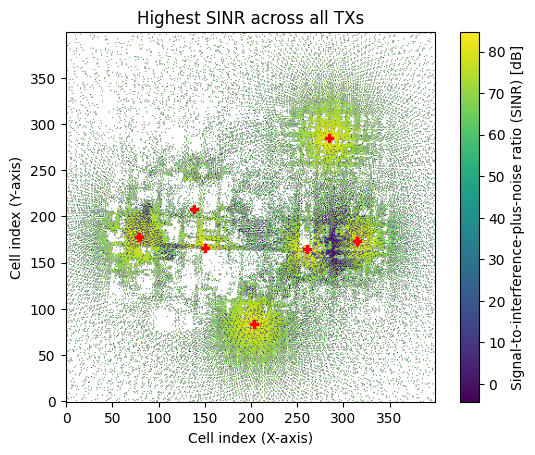

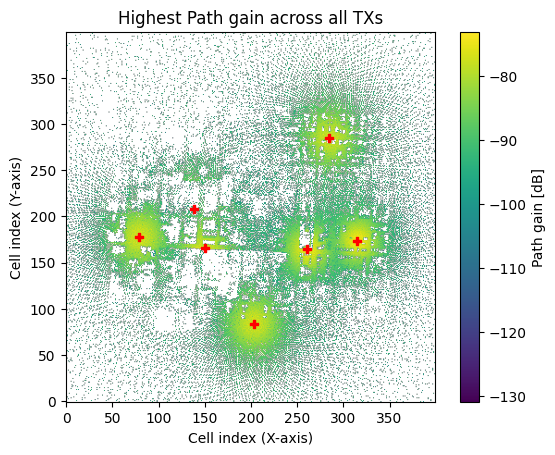

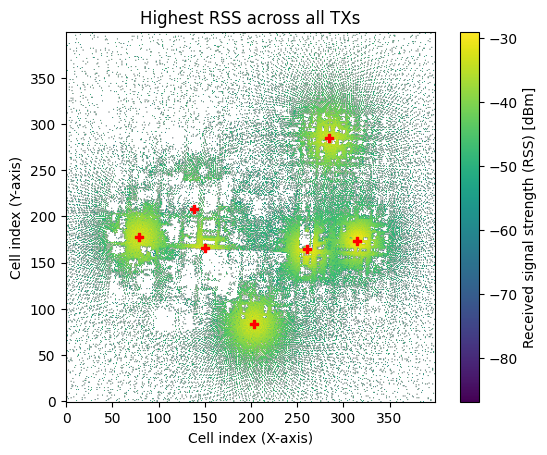

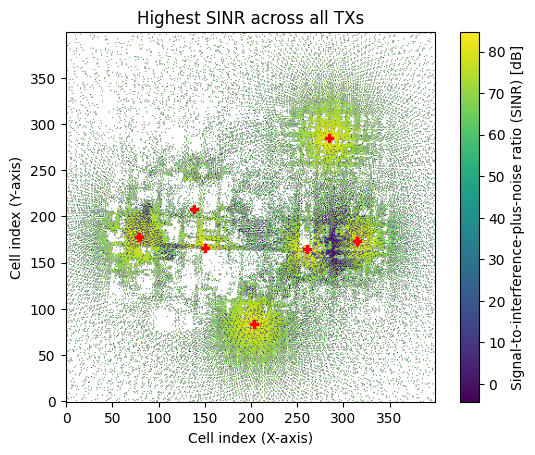

In [17]:
t = 0
rm = cache["radio_map"][t]

rm.show(metric="path_gain")
rm.show(metric="rss")
rm.show(metric="sinr")


In [9]:
print(radio_map)

In [ ]:
# eval_csv_path = PROJECT_ROOT / "eval_tools/model_a_eval/eval_rollout_raleigh_T50.csv"
eval_csv_path = PROJECT_ROOT / "eval_tools/model_a_eval/eval_rollout_atlanta_T50.csv"

# saved = save_eval_csv(df, eval_csv_path)
# print("Saved eval CSV:", saved)


In [ ]:
t = 10
gu_xyz = cache["gu_xyz"][t]
uav_xyz = cache["uav_xyz"][t]

# 2D
visualize_scene_2d(CFG_PATH, gu_xyz=gu_xyz, uav_xyz=uav_xyz, title=f"Eval frame t={t} (2D)")

# 3D
fig = visualize_scene_3d(CFG_PATH, gu_xyz=gu_xyz, uav_xyz=uav_xyz, title=f"Eval frame t={t} (3D)")
fig
